In [1]:
cd ..

/home/alberto/Work/course_interpretability_deep_learning


# Multi-omics stratification on PDAC patients

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import optuna
import dill
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.seed import isolate_rng
import torch
import seaborn as sns
from lifelines.statistics import multivariate_logrank_test
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
from lifelines.plotting import add_at_risk_counts
from scipy.stats import chi2_contingency, kruskal, wilcoxon

from src import settings
from utils import MultiViewDataset, transform_full_dataset
from optimization import Optimization

## Load dataset

In [4]:
clinical_data = pd.read_csv(settings.clinical_data_path, sep="\t")
clinical_data = clinical_data.set_index("Patient ID")
clinical_data.index.name = None
print("clinical_data.shape", clinical_data.shape)
clinical_data.head()

clinical_data.shape (186, 103)


Study ID        Sample ID  Diagnosis Age   
TCGA-2J-AAB1  paad_tcga  TCGA-2J-AAB1-01             65  \
TCGA-2J-AAB4  paad_tcga  TCGA-2J-AAB4-01             48   
TCGA-2J-AAB6  paad_tcga  TCGA-2J-AAB6-01             75   
TCGA-2J-AAB8  paad_tcga  TCGA-2J-AAB8-01             71   
TCGA-2J-AAB9  paad_tcga  TCGA-2J-AAB9-01             70   

             American Joint Committee on Cancer Metastasis Stage Code   
TCGA-2J-AAB1                                                 M0        \
TCGA-2J-AAB4                                                 M0         
TCGA-2J-AAB6                                                 M0         
TCGA-2J-AAB8                                                 M0         
TCGA-2J-AAB9                                                 M0         

             Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code   
TCGA-2J-AAB1                                                 N1                         \
TCGA-2J-AAB4                                                 N1                          
TCGA-2J-AAB6                                                 N0                          
TCGA-2J-AAB8                                                 N1                          
TCGA-2J-AAB9                                                 N1                          

             Neoplasm Disease Stage American Joint Committee on Cancer Code   
TCGA-2J-AAB1                                          Stage IIB              \
TCGA-2J-AAB4                                          Stage IIB               
TCGA-2J-AAB6                                          Stage IIA               
TCGA-2J-AAB8                                          Stage IIB               
TCGA-2J-AAB9                                          Stage IIB               

             American Joint Committee on Cancer Publication Version Type   
TCGA-2J-AAB1                                                7th           \
TCGA-2J-AAB4                                                7th            
TCGA-2J-AAB6                                                7th            
TCGA-2J-AAB8                                                7th            
TCGA-2J-AAB9                                                7th            

             American Joint Committee on Cancer Tumor Stage Code   
TCGA-2J-AAB1                                                 T3   \
TCGA-2J-AAB4                                                 T2    
TCGA-2J-AAB6                                                 T3    
TCGA-2J-AAB8                                                 T3    
TCGA-2J-AAB9                                                 T3    

              Alcohol Consumption Frequency Alcohol Exposure Intensity  ...   
TCGA-2J-AAB1                            3.0             Weekly Drinker  ...  \
TCGA-2J-AAB4                            NaN                        NaN  ...   
TCGA-2J-AAB6                            NaN                        NaN  ...   
TCGA-2J-AAB8                            NaN                        NaN  ...   
TCGA-2J-AAB9                            3.0             Weekly Drinker  ...   

             Adjuvant Postoperative Targeted Therapy Administered Indicator   
TCGA-2J-AAB1                                                YES              \
TCGA-2J-AAB4                                                YES               
TCGA-2J-AAB6                                                YES               
TCGA-2J-AAB8                                                YES               
TCGA-2J-AAB9                                                YES               

             Time between clamping and freezing   
TCGA-2J-AAB1                                NaN  \
TCGA-2J-AAB4                                NaN   
TCGA-2J-AAB6                                NaN   
TCGA-2J-AAB8                                NaN   
TCGA-2J-AAB9                                NaN   

             Time between excision and freezing Tissue Source Site   
TCGA-2J-AAB1

In [5]:
methylation_data = pd.read_csv(settings.methylation_data_path, sep=";", index_col=0, decimal=",")
methylation_data.columns = methylation_data.columns.str.replace(".", "-")
methylation_data = methylation_data.T
methylation_data = methylation_data.astype(np.float32)
print("methylation_data.shape", methylation_data.shape)
methylation_data.head()

methylation_data.shape (153, 301195)


cg00000029  cg00000236  cg00000289  cg00000292  cg00000321   
TCGA-2J-AAB6    0.157951    0.836226    0.710511    0.560780    0.239194  \
TCGA-2J-AAB8    0.300754    0.782242    0.574296    0.670286    0.424310   
TCGA-2J-AAB9    0.257807    0.846522    0.534748    0.688073    0.295597   
TCGA-2J-AABA    0.239086    0.789457    0.474723    0.705372    0.530321   
TCGA-2J-AABE    0.168622    0.841684    0.591205    0.623799    0.322576   

              cg00000622  cg00000658  cg00000714  cg00000721  cg00000734  ...   
TCGA-2J-AAB6    0.016433    0.864604    0.087681    0.938775    0.061008  ...  \
TCGA-2J-AAB8    0.014747    0.885958    0.112524    0.930765    0.037198  ...   
TCGA-2J-AAB9    0.014649    0.895039    0.167297    0.940112    0.058407  ...   
TCGA-2J-AABA    0.016919    0.884874    0.129581    0.910885    0.062167  ...   
TCGA-2J-AABE    0.014408    0.898202    0.125415    0.941153    0.059365  ...   

              ch.9.2262725R  ch.9.2285199R  ch.9.2298007R  ch.9.2473665R   
TCGA-2J-AAB6       0.103136       0.053757       0.032478            NaN  \
TCGA-2J-AAB8       0.028180       0.054483       0.022736            NaN   
TCGA-2J-AAB9       0.059313       0.063187       0.032581            NaN   
TCGA-2J-AABA       0.122677       0.056068       0.023190       0.109351   
TCGA-2J-AABE       0.046699       0.049177       0.032707            NaN   

              ch.9.357218F  ch.9.377428R  ch.9.691424R  ch.9.837340R   
TCGA-2J-AAB6      0.064965      0.049776      0.115268      0.095954  \
TCGA-2J-AAB8      0.060835      0.036434      0.160082      0.059216   
TCGA-2J-AAB9      0.055342      0.069086      0.128546      0.120015   
TCGA-2J-AABA      0.056015      0.053238      0.082979      0.057172   
TCGA-2J-AABE      0.075854      0.062602      0.122072      0.082753   

              ch.9.898515R  ch.9.991104F  
TCGA-2J-AAB6      0.084203           NaN  
TCGA-2J-AAB8      0.065342      0.166304  
TCGA-2J-AAB9      0.074940           NaN  
TCGA-2J-AABA      0.045781      0.121676  
TCGA-2J-AABE      0.071240           NaN  

[5 rows x 301195 columns]

In [8]:
rnaseq_data = pd.read_csv(settings.rnaseq_data_path, sep=";", index_col=0, decimal=",")
rnaseq_data = rnaseq_data.T
rnaseq_data = rnaseq_data.astype(np.float32)
print("rnaseq_data.shape", rnaseq_data.shape)
rnaseq_data.head()

rnaseq_data.shape (147, 20501)


A1BG       A1CF   A2BP1       A2LD1        A2ML1   
TCGA-2J-AAB6   82.549698   8.187100  0.0000  163.122803  1815.789551  \
TCGA-2J-AAB8   56.930698  33.842499  0.0000  185.814301    16.921301   
TCGA-2J-AAB9  105.787804  21.436199  1.0718  166.709503   642.015015   
TCGA-2J-AABA   99.345497  18.788200  0.0000   99.276703   873.649597   
TCGA-2J-AABE   79.401901   3.083100  0.0000  134.564499    74.610802   

                       A2M       A4GALT      A4GNT     AAA1        AAAS  ...   
TCGA-2J-AAB6   8517.444336  1121.052612   1.169600   1.1696  834.502930  ...  \
TCGA-2J-AAB8  14413.913086   392.949493   9.400700   0.9401  801.880127  ...   
TCGA-2J-AAB9  24311.779297  1125.401855  50.375099   0.0000  862.808105  ...   
TCGA-2J-AABA  10302.006836   633.161072   6.262700  18.7882  623.767029  ...   
TCGA-2J-AABE  11076.861328   710.343811  35.147202   0.0000  702.327698  ...   

                   ZXDA        ZXDB         ZXDC  ZYG11A      ZYG11B   
TCGA-2J-AAB6  14.619900  269.005798  1053.216431  0.5848  683.625671  \
TCGA-2J-AAB8  35.722698  356.286713   829.142212  3.7603  680.611023   
TCGA-2J-AAB9  57.877800  381.564789   936.763123  1.0718  646.302307   
TCGA-2J-AABA  52.606899  293.721588  1511.820923  1.2525  945.670898   
TCGA-2J-AABE  56.728802  431.632507  1069.215454  0.6166  564.205322   

                       ZYX        ZZEF1        ZZZ3  psiTPTE22    tAKR  
TCGA-2J-AAB6  11696.491211   869.005798  601.754395  26.315800  0.0000  
TCGA-2J-AAB8   5829.377441   828.202087  609.165710  85.546402  0.0000  
TCGA-2J-AAB9   8094.319336  1083.601318  573.419128  30.010700  0.0000  
TCGA-2J-AABA   4829.810547  1364.646851  793.486816  31.313601  0.6263  
TCGA-2J-AABE   7464.775879   832.434082  468.629608  48.096199  0.0000  

[5 rows x 20501 columns]

In [9]:
samples = methylation_data.index.intersection(rnaseq_data.index)
methylation_data = methylation_data.loc[samples]
rnaseq_data = rnaseq_data.loc[samples]
assert methylation_data.index.equals(rnaseq_data.index)
clinical_data = clinical_data.loc[samples]
assert methylation_data.index.equals(clinical_data.index)
Xs= [rnaseq_data, methylation_data]
print("common samples:", len(samples))

common samples: 147


In [10]:
date = "2023070315"
with open(os.path.join(settings.optimization_path, f'optimization_optuna_{date}.pkl'), 'rb') as file:
    optimization_study = dill.load(file)

In [11]:
optimization_results = pd.read_csv(os.path.join(settings.optimization_path, f"optimization_results_{date}.csv"))
best_trial = optimization_results.iloc[0]
print("optimization_results.shape", optimization_results.shape)
optimization_results.head()

optimization_results.shape (1220, 58)


number     value              datetime_start           datetime_complete   
0    1127  0.281159  2023-07-07 07:01:25.882040  2023-07-07 07:08:24.600525  \
1    1149  0.279001  2023-07-07 08:41:07.673127  2023-07-07 08:48:38.017987   
2    1196  0.269337  2023-07-07 12:47:37.526021  2023-07-07 12:55:08.465497   
3    1084  0.265154  2023-07-07 03:25:02.458722  2023-07-07 03:27:56.844037   
4    1130  0.264482  2023-07-07 07:17:42.352880  2023-07-07 07:24:47.307330   

                 duration  params_divisor_units   
0  0 days 00:06:58.718485                     2  \
1  0 days 00:07:30.344860                     2   
2  0 days 00:07:30.939476                     2   
3  0 days 00:02:54.385315                     4   
4  0 days 00:07:04.954450                     2   

   params_features_per_component  params_lambda_coeff  params_latent_space   
0                             10             0.014074                   50  \
1                             10             0.007898                   50   
2                             10             0.013482                   50   
3                             10             0.010966                   50   
4                             10             0.010072                   50   

   params_n_clusters  ...  user_attrs_val_dist_loss   
0                2.0  ...                112.288543  \
1                2.0  ...                122.397693   
2                2.0  ...                 99.369842   
3                2.0  ...                 35.438107   
4                2.0  ...                123.094148   

                       user_attrs_val_dist_loss_list user_attrs_val_loss   
0  [80.92032623291016, 158.0206298828125, 182.946...            0.594707  \
1  [188.0741424560547, 101.92342376708984, 78.606...            0.596372   
2  [111.77200317382812, 218.13812255859375, 86.58...            0.595154   
3  [20.836471557617188, 53.32878494262695, 22.022...            0.596461   
4  [197.2069854736328, 140.8181610107422, 55.0165...            0.594263   

                            user_attrs_val_loss_list   
0  [0.5835521817207336, 0.6417752504348755, 0.592...  \
1  [0.6067892909049988, 0.6313546895980835, 0.588...   
2  [0.5886245965957642, 0.6277905106544495, 0.585...   
3  [0.5911136269569397, 0.6372606158256531, 0.591...   
4  [0.5875703692436218, 0.6417000889778137, 0.571...   

              user_attrs_val_loss_view_list user_attrs_val_silhscore   
0  [0.5626613163948059, 0.6267521572113037]                 0.281159  \
1  [0.5653188920021057, 0.6274248051643372]                 0.279001   
2  [0.5625463891029358, 0.6277625322341919]                 0.269337   
3  [0.5633599877357482, 0.6295623540878296]                 0.265154   
4  [0.5615304493904114, 0.6269950985908508]                 0.264482   

                       user_attrs_val_silhscore_list   
0  [0.17513557, 0.20066147, 0.33802804, 0.1914916...  \
1  [0.29767722, 0.18416011, 0.34523594, 0.1691730...   
2  [0.17461367, 0.19133604, 0.22703034, 0.2376199...   
3  [0.25051585, 0.208064, 0.21120243, 0.29239604,...   
4  [0.21908401, 0.21233779, 0.10679189, 0.1546428...   

   user_attrs_val_total_loss   
0                   2.175859  \
1                   1.563155   
2                   1.934152   
3                   0.987910   
4                   1.834330   

                      user_attrs_val_total_loss_list     state  
0  [1.7208877801895142, 2.867652177810669, 3.1697...  COMPLETE  
1  [2.0907042026519775, 1.4374117851257324, 1.207...  COMPLETE  
2  [2.0977280139923096, 3.569657564163208, 1.7522...  COMPLETE  
3  [0.8248596787452698, 1.2237839698791504, 0.833...  COMPLETE  
4  [2.5816493034362793, 2.060253143310547, 1.1255...  COMPLETE  

[5 rows x 58 columns]

In [70]:
param_importances = optuna.importance.get_param_importances(optimization_study)

In [27]:
max_value = optimization_results["value"].min()
max_values = []
for i in optimization_results.sort_values(by= "number")["value"]:
    if i > max_value:
        max_value = i
    max_values.append(max_value)

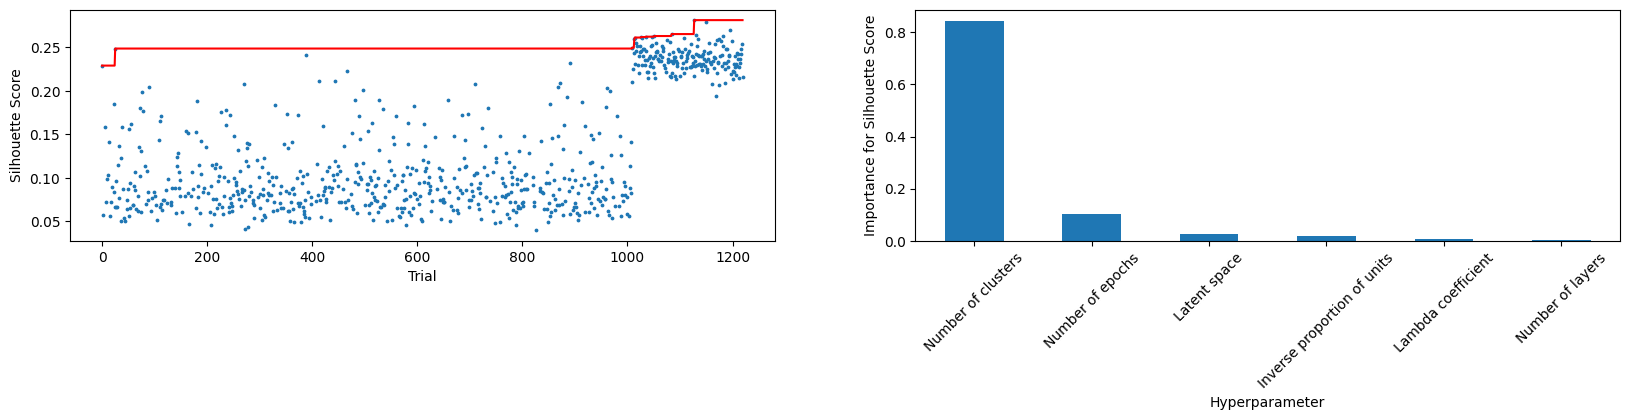

In [79]:
date = "2023070315"
with open(os.path.join(settings.optimization_path, f'optimization_optuna_{date}.pkl'), 'rb') as file:
    optimization_study = dill.load(file)

fig, axes = plt.subplots(1,2, figsize= (20, 3))

ax= axes[0]
optimization_results.plot.scatter(x='number', y='value', ax= ax, s= 3, xlabel= "Trial", ylabel= "Silhouette Score")
pd.Series(max_values).plot(ax= ax, c= "red")

ax= axes[1]
pd.Series(param_importances).plot.bar(ax= ax, xlabel= "Hyperparameter", ylabel= "Importance for Silhouette Score", rot= 4top25_neuron10_fi.png)
_ = ax.set_xticklabels(["Number of clusters", "Number of epochs", "Latent space", "Inverse proportion of units", "Lambda coefficient", "Number of layers"])

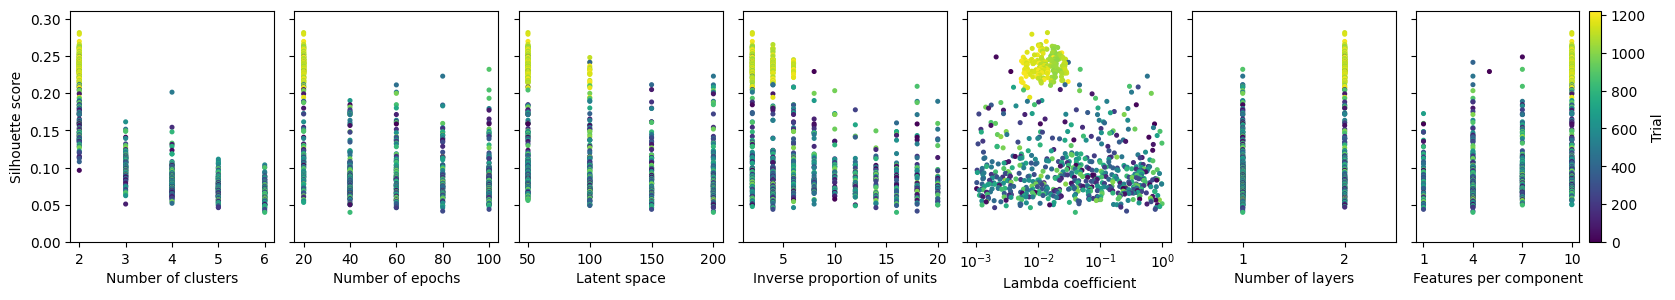

In [19]:
fig, axes = plt.subplots(1,7, sharey=True, figsize= (20, 3), gridspec_kw = {"wspace": 0.1})

for i, col in enumerate(["params_n_clusters", "params_n_epochs", "params_latent_space", "params_divisor_units",
                         "params_lambda_coeff", "params_num_layers", "params_features_per_component"]):
    ax = axes[i]
    if col == "params_lambda_coeff":
        optimization_results.plot.scatter(x= col, y= "value", s= 7, ax=ax, ylabel= "Silhouette score", xlabel= "Lambda coefficient",
                                          logx= True, xticks= [0.001, 0.01, 0.1, 1], c= "number", colorbar= False, cmap = 'viridis')
    elif col == "params_features_per_component":
        optimization_results.plot.scatter(x= col, y= "value", s= 7, ax=ax, ylabel= "Silhouette score", xlabel= "Features per component",
                                          xticks= [1,4,7,10], c= "number", colorbar= True, cmap = 'viridis')
        ax.collections[-1].colorbar.set_label("Trial")
        # ax.set_cmap('viridis')
    elif col == "params_n_clusters":
        optimization_results.plot.scatter(x= col, y= "value", s= 7, ax=ax, ylabel= "Silhouette score", xlabel= "Number of clusters",
                                          xticks= list(range(2,7)), c= "number", colorbar= False, cmap = 'viridis')
    elif col == "params_n_epochs":
        optimization_results.plot.scatter(x= col, y= "value", s= 7, ax=ax, ylabel= "Silhouette score", xlabel= "Number of epochs",
                                          xticks= [20,40,60,80,100], c= "number", colorbar= False, cmap = 'viridis')
    elif col == "params_num_layers":
        optimization_results.plot.scatter(x= col, y= "value", s= 7, ax=ax, ylabel= "Silhouette score", xlabel= "Number of layers",
                                          xticks= [1,2], c= "number", colorbar= False, cmap = 'viridis')
        ax.set_xlim(0.5,2.5)
    elif col == "params_latent_space":
        optimization_results.plot.scatter(x= col, y= "value", s= 7, ax=ax, ylabel= "Silhouette score", xlabel= "Latent space",
                                          c= "number", colorbar= False, cmap = 'viridis')
    elif col == "params_divisor_units":
        optimization_results.plot.scatter(x= col, y= "value", s= 7, ax=ax, ylabel= "Silhouette score", xlabel= "Inverse proportion of units",
                                          c= "number", colorbar= False, cmap = 'viridis')

_ = ax.set_ylim(0,0.31)

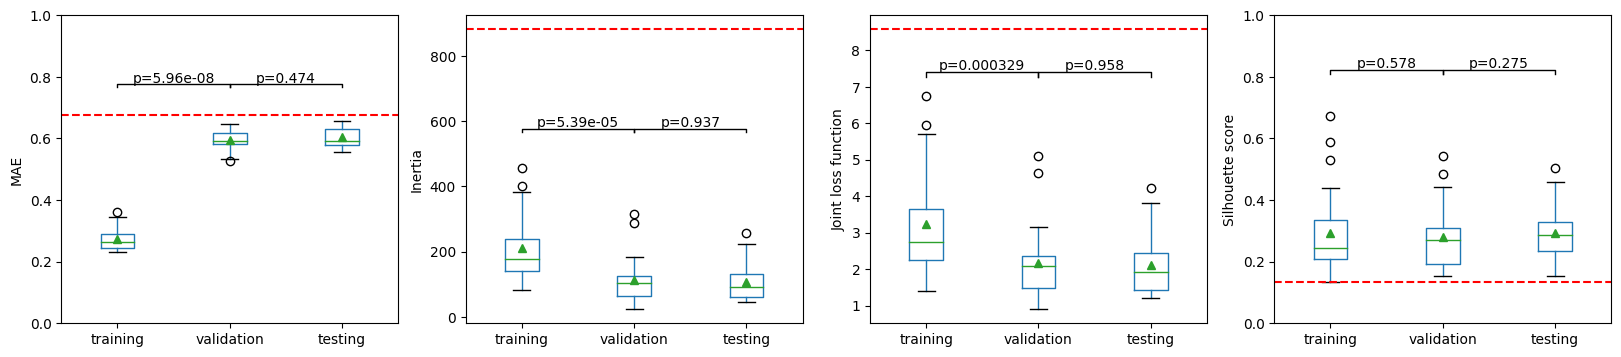

In [504]:
fig, axes = plt.subplots(1, 4, figsize= (20, 4))
ax, metric = axes[0], "au"
metric_index = ["training", "validation", "testing"]
metric_result = pd.DataFrame(optimization_results.iloc[0][[f"user_attrs_train_{metric}_loss_list", f"user_attrs_val_{metric}_loss_list",
                                           f"user_attrs_test_{metric}_loss_list"]].apply(eval).to_list(), index= metric_index).T
metric_result.boxplot(grid=False, showmeans= True, ax= ax)
bottom, top = ax.get_ylim()
y_range = top - bottom
bar_height = (y_range * 0.07 * 3) + top
bar_tips = bar_height - (y_range * 0.02)
text_height = bar_height + (y_range * 0.01)
for idx,met in enumerate(metric_index[:2]):
    pv = wilcoxon(metric_result[met], metric_result[metric_result.columns[idx + 1]]).pvalue
    ax.plot([idx+1, idx+1, idx+2, idx+2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    ax.text((idx + idx + 3) * 0.5, text_height, 'p={:.3g}'.format(pv), ha='center', c='k')
ax.set_ylim(0, 1)
ax.axhline(optimization_results[f"user_attrs_test_{metric}_loss"].max(), c= "r", linestyle= '--')
ax.set_ylabel('MAE')

ax, metric = axes[1], "dist"
metric_result = pd.DataFrame(optimization_results.iloc[0][[f"user_attrs_train_{metric}_loss_list", f"user_attrs_val_{metric}_loss_list",
                                           f"user_attrs_test_{metric}_loss_list"]].apply(eval).to_list(), index= metric_index).T
metric_result.boxplot(grid=False, showmeans= True, ax= ax)
bottom, top = ax.get_ylim()
y_range = top - bottom
bar_height = (y_range * 0.07 * 3) + top
bar_tips = bar_height - (y_range * 0.02)
text_height = bar_height + (y_range * 0.01)
for idx,met in enumerate(metric_index[:2]):
    pv = wilcoxon(metric_result[met], metric_result[metric_result.columns[idx + 1]]).pvalue
    ax.plot([idx+1, idx+1, idx+2, idx+2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    ax.text((idx + idx + 3) * 0.5, text_height, 'p={:.3g}'.format(pv), ha='center', c='k')
ax.axhline(optimization_results[optimization_results["params_n_clusters"] == 2][f"user_attrs_test_{metric}_loss"].mean(), c= "r", linestyle= '--')
ax.set_ylabel('Inertia')

ax, metric = axes[2], "total"
metric_result = pd.DataFrame(optimization_results.iloc[0][[f"user_attrs_train_{metric}_loss_list", f"user_attrs_val_{metric}_loss_list",
                                           f"user_attrs_test_{metric}_loss_list"]].apply(eval).to_list(), index= metric_index).T
metric_result.boxplot(grid=False, showmeans= True, ax= ax)
bottom, top = ax.get_ylim()
y_range = top - bottom
bar_height = (y_range * 0.07 * 3) + top - 1
bar_tips = bar_height - (y_range * 0.02)
text_height = bar_height + (y_range * 0.01)
for idx,met in enumerate(metric_index[:2]):
    pv = wilcoxon(metric_result[met], metric_result[metric_result.columns[idx + 1]]).pvalue
    ax.plot([idx+1, idx+1, idx+2, idx+2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    ax.text((idx + idx + 3) * 0.5, text_height, 'p={:.3g}'.format(pv), ha='center', c='k')
ax.axhline(optimization_results[optimization_results["params_lambda_coeff"].between(0.012, 0.016)][f"user_attrs_test_{metric}_loss"].max(), c= "r", linestyle= '--')
ax.set_ylabel('Joint loss function')


ax, metric = axes[3], "silhscore"
metric_result = pd.DataFrame(optimization_results.iloc[0][[f"user_attrs_train_{metric}_list", f"user_attrs_val_{metric}_list",
                                           f"user_attrs_test_{metric}_list"]].apply(eval).to_list(), index= metric_index).T
metric_result.boxplot(grid=False, showmeans= True, ax= ax)
bottom, top = ax.get_ylim()
y_range = top - bottom
bar_height = (y_range * 0.07 * 3) + top
bar_tips = bar_height - (y_range * 0.02)
text_height = bar_height + (y_range * 0.01)
for idx,met in enumerate(metric_index[:2]):
    pv = wilcoxon(metric_result[met], metric_result[metric_result.columns[idx + 1]]).pvalue
    ax.plot([idx+1, idx+1, idx+2, idx+2], [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    ax.text((idx + idx + 3) * 0.5, text_height, 'p={:.3g}'.format(pv), ha='center', c='k')
ax.set_ylabel('Silhouette score')
ax.set_ylim(0, 1)
_ = ax.axhline(optimization_results[f"user_attrs_test_{metric}"].mean(), c= "r", linestyle= '--')

In [10]:
# transformed_Xs = transform_full_dataset(Xs=Xs, fit_pipelines = True, results_folder = settings.results_path, 
#                                         features_per_component = optimization_study.best_params["features_per_component"],
#                                         optimization_folder = settings.optimization_path)
transformed_Xs = transform_full_dataset(Xs=Xs, fit_pipelines = False, results_folder = settings.results_path)
for transformed_X in transformed_Xs:
    print("transformed_X.shape", transformed_X.shape)
    display(transformed_X.head())

transformed_X.shape (147, 5120)


A2ML1       A2M    A4GALT     AADAC      AAMP      AARS   
TCGA-2J-AAB6  1.337566 -0.995322  0.709940 -0.482025 -0.994043 -0.500406  \
TCGA-2J-AAB8 -0.263078 -0.312616 -0.466568 -0.092760  0.365986 -0.484396   
TCGA-2J-AAB9  0.293135  0.833378  0.716968 -0.244825 -0.678968 -0.453602   
TCGA-2J-AABA  0.499244 -0.788701 -0.078421 -0.385282  0.184817 -0.670856   
TCGA-2J-AABE -0.211745 -0.698987  0.046295 -0.167821  0.721762 -0.584655   

                 ABCA1     ABCA2     ABCA3     ABCA5  ...     ZNF83    ZNF862   
TCGA-2J-AAB6 -0.617043  0.025660 -0.993760 -0.916834  ...  4.256368 -0.319655  \
TCGA-2J-AAB8 -0.752298 -1.017359 -1.037290 -0.983338  ... -0.843497 -0.252332   
TCGA-2J-AAB9 -0.894353 -0.992373  0.142981  0.175134  ... -0.433304 -0.569170   
TCGA-2J-AABA  0.067303  1.108192 -0.937203 -0.121891  ...  0.761861  0.687225   
TCGA-2J-AABE -0.515060  0.903657 -0.765430 -1.021597  ...  1.232995  0.854789   

                 ZNFX1     ZNRD1    ZRANB2   ZSCAN18    ZSWIM4      ZXDC   
TCGA-2J-AAB6  0.383429 -0.377239  0.578712  0.231294 -0.624743  0.201198  \
TCGA-2J-AAB8 -0.394491 -0.443371  1.128145 -0.683703  1.246422 -0.807551   
TCGA-2J-AAB9 -0.528678 -0.594227 -0.977925  0.717373  1.374004 -0.323058   
TCGA-2J-AABA -0.387668 -0.508557  1.502279 -0.583605 -0.385826  2.265767   
TCGA-2J-AABE -0.419889 -0.557223  0.094279 -0.775345  1.208995  0.273223   

                ZYG11B       ZYX  
TCGA-2J-AAB6 -0.116993  2.956858  
TCGA-2J-AAB8 -0.130869 -0.039890  
TCGA-2J-AAB9 -0.288796  1.116975  
TCGA-2J-AABA  1.089225 -0.550439  
TCGA-2J-AABE -0.666695  0.795423  

[5 rows x 5120 columns]

transformed_X.shape (147, 5120)


cg00003298  cg00021108  cg00024472  cg00025496  cg00031165   
TCGA-2J-AAB6    1.340063    1.500479    0.330473   -2.437752    0.585663  \
TCGA-2J-AAB8   -0.318397   -0.600886   -0.493560   -0.522029    0.966517   
TCGA-2J-AAB9   -1.239376   -0.537383   -0.574154   -0.596666   -1.040670   
TCGA-2J-AABA    0.473446   -0.545187   -0.541977    0.039966   -0.946297   
TCGA-2J-AABE    0.585490   -0.565795   -0.525130   -0.450983    0.297698   

              cg00032884  cg00041599  cg00042882  cg00058329  cg00061520  ...   
TCGA-2J-AAB6   -0.384227   -0.933534   -1.404847    1.556353    0.786654  ...  \
TCGA-2J-AAB8    0.779119    0.896017   -0.106885   -0.238159   -0.337662  ...   
TCGA-2J-AAB9    0.987377    0.176860   -0.104806   -1.331851    1.205454  ...   
TCGA-2J-AABA    0.023089   -0.874169   -0.986266    0.645963    0.731187  ...   
TCGA-2J-AABE    0.971295   -0.103786    1.191861   -0.759940    0.075504  ...   

              cg27594157  cg27594756  cg27610821  cg27616227  cg27633530   
TCGA-2J-AAB6    1.172822   -0.158712   -0.823215   -1.693980    1.363548  \
TCGA-2J-AAB8   -0.775050   -0.460455   -0.760774   -1.272152    0.102773   
TCGA-2J-AAB9   -0.048385   -0.226124   -0.866286    0.564234   -1.219404   
TCGA-2J-AABA   -0.836188    1.551527   -1.017153    0.405024    0.700272   
TCGA-2J-AABE   -1.046977   -0.314683    1.008485    0.421982   -1.224547   

              cg27641961  cg27645259  cg27648738  cg27649073  cg27664689  
TCGA-2J-AAB6   -1.496673    2.282258    1.486526   -0.865494   -1.595479  
TCGA-2J-AAB8   -0.765774   -0.597939    0.576464    0.719743   -0.701581  
TCGA-2J-AAB9    1.289739   -0.342804   -1.038833   -0.102618   -0.528777  
TCGA-2J-AABA   -0.569468   -0.688826   -0.836018   -0.624695   -0.653387  
TCGA-2J-AABE   -0.489625   -0.628166   -0.558183   -0.415640   -0.751258  

[5 rows x 5120 columns]

In [11]:
batch_size = int(best_trial["user_attrs_batch_size"])
full_data = MultiViewDataset(Xs=transformed_Xs)
full_dataloader = DataLoader(dataset=full_data, batch_size=batch_size, shuffle=True)
with isolate_rng():
    total_results = Optimization().training(n_clusters = optimization_study.best_params["n_clusters"], latent_space=optimization_study.best_params["latent_space"],
                                            in_channels_list = eval(best_trial["user_attrs_num_features"]),
                                            hidden_channels_list = [view_hidden[1:] for view_hidden in eval(best_trial["user_attrs_num_units"])], 
                                            train_dataloader = full_dataloader, val_dataloader = full_dataloader, test_dataloader = full_dataloader,
                                            n_epochs = optimization_study.best_params["n_epochs"],
                                            log_every_n_steps = np.ceil(len(full_data) / batch_size).astype(int),
                                            lambda_coeff = optimization_study.best_params["lambda_coeff"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasin

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 98 steps due to diverging loss.
Learning rate set to 0.0002511886431509582
Restoring states from the checkpoint path at /home/alberto/Work/course_interpretability_deep_learning/.lr_find_ad7514de-53f5-449b-bfeb-38d19dd2038a.ckpt
Restored all states from the checkpoint at /home/alberto/Work/course_interpretability_deep_learning/.lr_find_ad7514de-53f5-449b-bfeb-38d19dd2038a.ckpt
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | encoder_0 | FCN        | 16.4 M
1 | decoder_0 | FCN        | 19.7 M
2 | encoder_1 | FCN        | 16.4 M
3 | decoder_1 | FCN        | 19.7 M
4 | encoder_2 | Sequential | 128 K 
5 | decoder_2 | FCN        | 135 K 
-----------------------------------------
72.4 M    Trainable params
0         Non-trainable params
72

In [12]:
model = total_results["model"]
model_path = os.path.join("outputs", "models", "model_state_dict.pt")
torch.save(model.state_dict(), model_path)
model_path = os.path.join("outputs", "models", "model.pt")
torch.save(model, model_path)
model = model.eval()

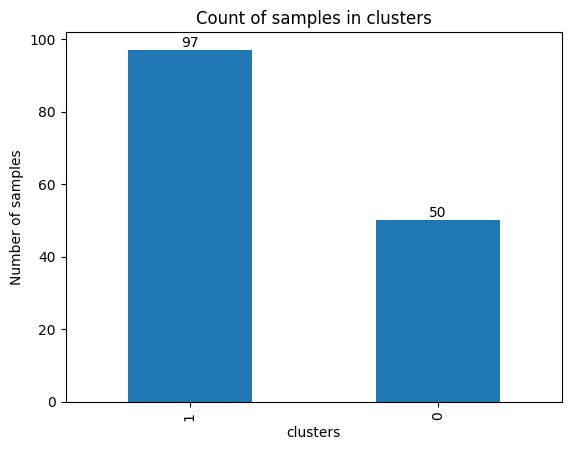

In [13]:
full_data = MultiViewDataset(Xs=[X_.loc[clinical_data.index] for X_ in transformed_Xs])
full_dataloader = DataLoader(dataset=full_data, batch_size=batch_size, shuffle=False)
with torch.no_grad():
    z_full = torch.vstack([model.autoencoder.encode(batch) for batch in full_dataloader])
    clusters = model.predict_cluster_from_embedding(z_full).detach().cpu().numpy()
z_full = pd.DataFrame(z_full)
clinical_data["clusters"] = clusters
ax = clinical_data["clusters"].value_counts().plot(kind="bar", title= "Count of samples in clusters", x= "clusters", ylabel= "Number of samples")
for container in ax.containers:
    ax.bar_label(container)

In [344]:
clustering_statistical_table = pd.DataFrame([], columns= ["Deep clustering", "K-Means", "HC"], index= ["Overall Survival", "Diagnosis age", "AJCC tumor stage",
                                                                                                       "AJCC metastasis stage", "AJCC neoplasm histologic grade", "Sex"])
clustering_statistical_table

Deep clustering K-Means   HC
Overall Survival                           NaN     NaN  NaN
Diagnosis age                              NaN     NaN  NaN
AJCC tumor stage                           NaN     NaN  NaN
AJCC metastasis stage                      NaN     NaN  NaN
AJCC neoplasm histologic grade             NaN     NaN  NaN
Sex                                        NaN     NaN  NaN

In [384]:
logrank_test = multivariate_logrank_test(event_durations= clinical_data["Overall Survival (Months)"], groups= clinical_data["clusters"])
logrank_test

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          10.12 <0.005      9.41

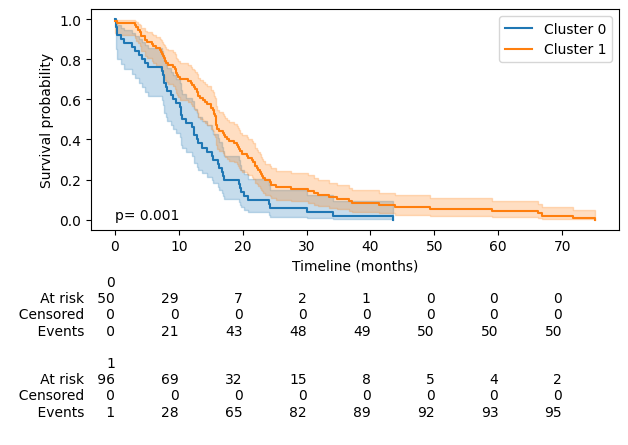

In [480]:
ax = plt.subplot(111)
ax.text(0, 0, f"p= {round(logrank_test.p_value, 3)}")
clustering_statistical_table.loc["Overall Survival", "Deep clustering"] = logrank_test.p_value
kmfs = []
colors = ['y', 'm']
for cluster in sorted(clinical_data["clusters"].unique()):
    duration = clinical_data["Overall Survival (Months)"][clinical_data["clusters"] == cluster]
    kmf = KaplanMeierFitter().fit(duration, label = str(cluster))
    kmfs.append(kmf)
    ax = kmf.plot(ax=ax)

add_at_risk_counts(*kmfs, ax=ax)
ax.set_ylabel("Survival probability")
ax.set_xlabel("Timeline (months)")
for i,cl in enumerate(ax.legend().get_texts()):
    cl.set_text(f'Cluster {i}')
plt.tight_layout()

<lifelines.CoxPHFitter: fitted with 147 total observations, 0 right-censored observations>
             duration col = 'Overall Survival (Months)'
      baseline estimation = breslow
   number of observations = 147
number of events observed = 147
   partial log-likelihood = -585.36
         time fit was run = 2023-09-18 08:22:37 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
clusters    0.56       1.75       0.18             0.21             0.91                 1.24                 2.49

            cmp to    z      p   -log2(p)
covariate                                
clusters      0.00 3.14 <0.005       9.21
---
Concordance = 0.57
Partial AIC = 1172.72
log-likelihood ratio test = 9.30 on 1 df
-log2(p) of ll-ratio test = 8.77

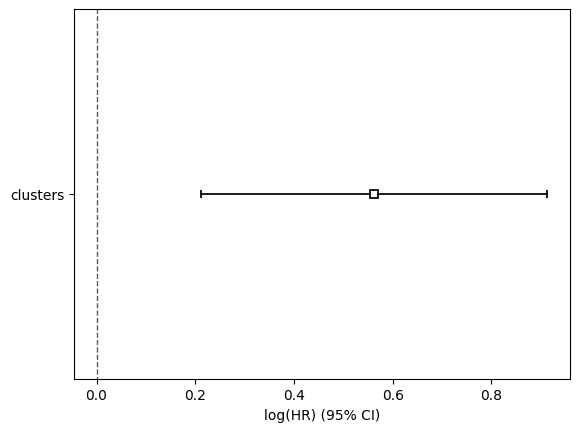

In [271]:
cph = CoxPHFitter()
cph.fit(clinical_data[['Overall Survival (Months)', "clusters"]].replace({"clusters": 0}, 2).replace({"clusters": 1}, 0).replace({"clusters": 2}, 1), duration_col = 'Overall Survival (Months)').print_summary()
_ = cph.plot()

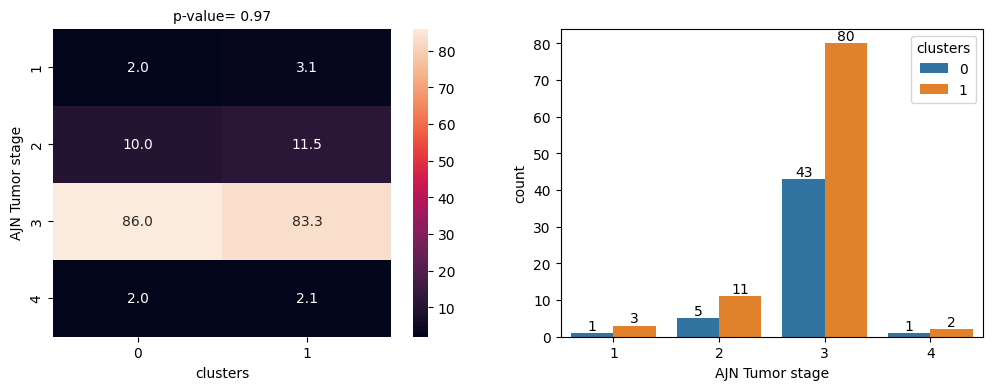

In [352]:
clinical_label = "American Joint Committee on Cancer Tumor Stage Code"
clinical_parameter = clinical_data[clinical_label].str[-1].astype(float).dropna().astype(int)
clinical_label = "AJN Tumor stage"
clinical_parameter = clinical_parameter.rename(clinical_label)
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['clusters'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['clusters'])).pvalue
clustering_statistical_table.loc["AJCC tumor stage", "Deep clustering"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["clusters"] = clinical_data['clusters']
sns.countplot(data= clinical_parameter, x= clinical_label, hue= "clusters", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

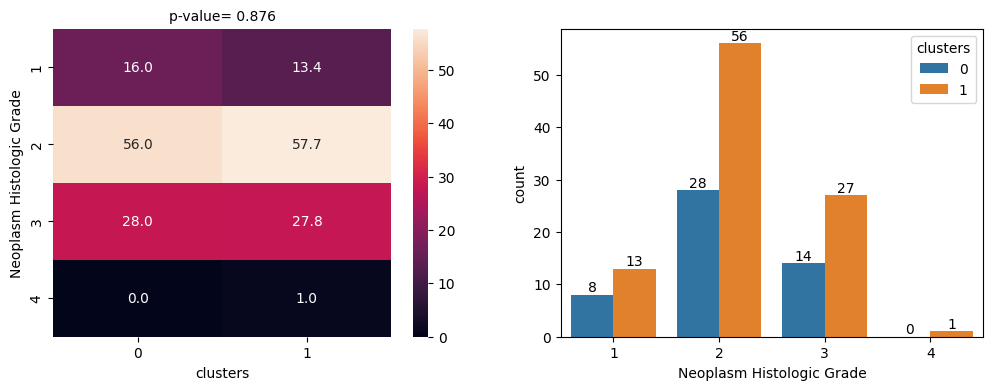

In [353]:
clinical_label = "Neoplasm Histologic Grade"
clinical_parameter = clinical_data[clinical_label].str[-1].astype(float).dropna().astype(int)
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['clusters'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['clusters'])).pvalue
clustering_statistical_table.loc["AJCC neoplasm histologic grade", "Deep clustering"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["clusters"] = clinical_data['clusters']
sns.countplot(data= clinical_parameter, x= clinical_label, hue= "clusters", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

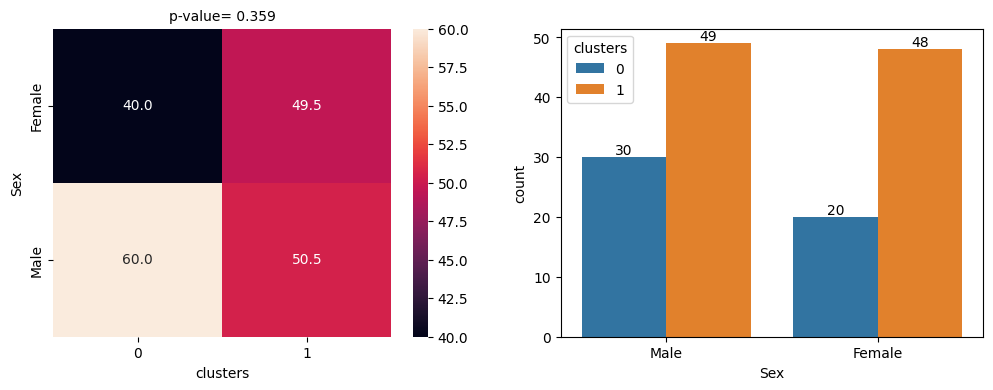

In [356]:
clinical_label = "Sex"
clinical_parameter = clinical_data[clinical_label]
crosstab = pd.crosstab(clinical_parameter, clinical_data['clusters'])
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['clusters'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
clinical_parameter = pd.get_dummies(clinical_data[clinical_label], drop_first=True).astype(int).squeeze()
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['clusters'])).pvalue
clustering_statistical_table.loc["Sex", "Deep clustering"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["clusters"] = clinical_data['clusters']
sns.countplot(data= clinical_data, x= clinical_label, hue= "clusters", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

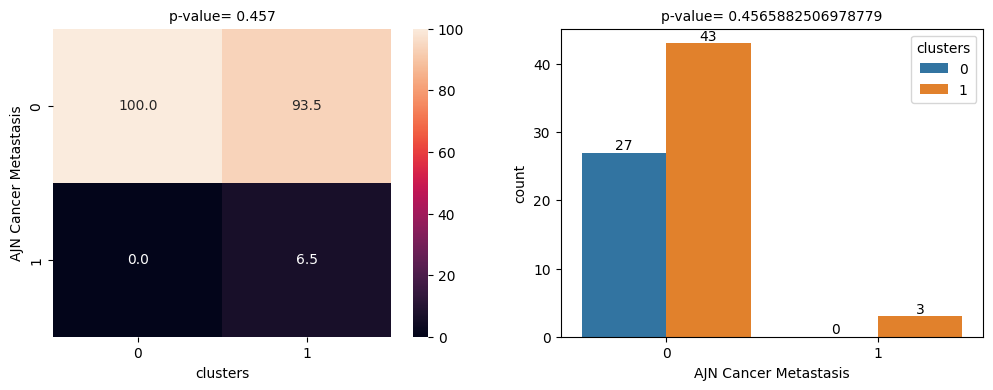

In [357]:
clinical_label = "American Joint Committee on Cancer Metastasis Stage Code"
clinical_parameter = clinical_data[clinical_label].str[-1]
clinical_parameter = clinical_parameter[clinical_parameter != "X"]
clinical_parameter = clinical_parameter.astype(float).dropna().astype(int)
clinical_label = "AJN Cancer Metastasis"
clinical_parameter = clinical_parameter.rename(clinical_label)
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['clusters'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['clusters'])).pvalue
clustering_statistical_table.loc["AJCC metastasis stage", "Deep clustering"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["clusters"] = clinical_data['clusters']
ax= sns.countplot(data= clinical_parameter, x= clinical_label, hue= "clusters")
ax.set_title(f"p-value= {pval}", fontsize= 10)
for container in ax.containers:
    ax.bar_label(container)

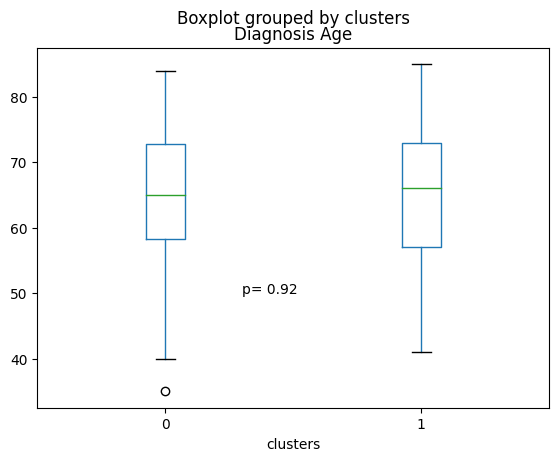

In [358]:
clinical_label = "Diagnosis Age"
clinical_parameter = clinical_data[clinical_label].dropna()
pval = kruskal(*[clinical_parameter[clinical_data['clusters'] == cl] for cl in clinical_data['clusters'].unique()]).pvalue
clustering_statistical_table.loc["Diagnosis age", "Deep clustering"] = pval
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["clusters"] = clinical_data['clusters']
ax = clinical_parameter.boxplot(column= clinical_label, by= "clusters", grid=False)
_ = ax.text(1.3, 50, f"p= {round(pval, 3)}")

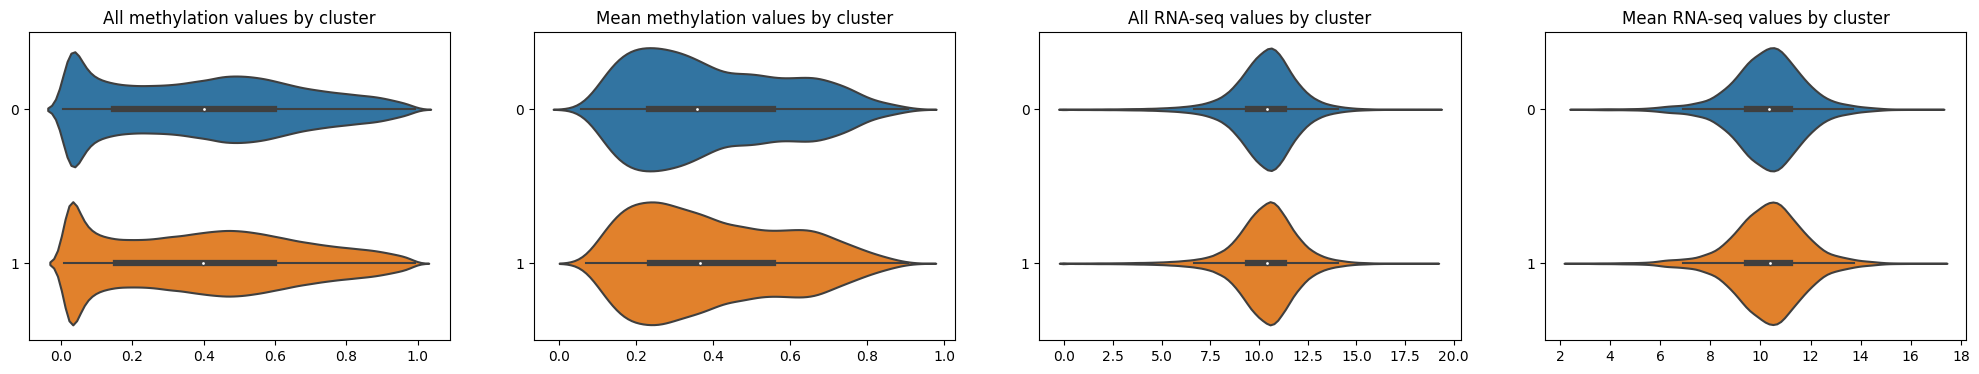

In [265]:
fig, axes = plt.subplots(1, 4, figsize= (25, 4))

ax = sns.violinplot(data= pd.DataFrame([methylation_data.loc[clinical_data[clinical_data["clusters"] == cl].index, transformed_Xs[1].columns].values.flatten() for cl in sorted(clinical_data["clusters"].unique())],
                                   index = [cl for cl in sorted(clinical_data["clusters"].unique())]).T,
                    orient= "h", ax = axes[0])
ax.set_title("All methylation values by cluster")

ax = sns.violinplot(data= pd.DataFrame([methylation_data.loc[clinical_data[clinical_data["clusters"] == cl].index, transformed_Xs[1].columns].mean(0) for cl in sorted(clinical_data["clusters"].unique())],
                                   index = [cl for cl in sorted(clinical_data["clusters"].unique())]).T,
                    orient= "h", ax = axes[1])
ax.set_title("Mean methylation values by cluster")

ax = sns.violinplot(data= pd.DataFrame([rnaseq_data.loc[clinical_data[clinical_data["clusters"] == cl].index, transformed_Xs[0].columns].apply(lambda x: np.log2(1 + x)).values.flatten() for cl in sorted(clinical_data["clusters"].unique())],
                                   index = [cl for cl in sorted(clinical_data["clusters"].unique())]).T,
                    orient= "h", ax = axes[2])
ax.set_title("All RNA-seq values by cluster")

ax = sns.violinplot(data= pd.DataFrame([rnaseq_data.loc[clinical_data[clinical_data["clusters"] == cl].index, transformed_Xs[0].columns].apply(lambda x: np.log2(1 + x)).mean(0) for cl in sorted(clinical_data["clusters"].unique())],
                                   index = [cl for cl in sorted(clinical_data["clusters"].unique())]).T,
                    orient= "h", ax = axes[3])
= ax.set_title("Mean RNA-seq values by cluster")

In [22]:
transformed_X = pd.concat(transformed_Xs, axis = 1)
print("transformed_X.shape", transformed_X.shape)
transformed_X.head()

transformed_X.shape (147, 10240)


A2ML1       A2M    A4GALT     AADAC      AAMP      AARS   
TCGA-2J-AAB6  1.337566 -0.995322  0.709940 -0.482025 -0.994043 -0.500406  \
TCGA-2J-AAB8 -0.263078 -0.312616 -0.466568 -0.092760  0.365986 -0.484396   
TCGA-2J-AAB9  0.293135  0.833378  0.716968 -0.244825 -0.678968 -0.453602   
TCGA-2J-AABA  0.499244 -0.788701 -0.078421 -0.385282  0.184817 -0.670856   
TCGA-2J-AABE -0.211745 -0.698987  0.046295 -0.167821  0.721762 -0.584655   

                 ABCA1     ABCA2     ABCA3     ABCA5  ...  cg27594157   
TCGA-2J-AAB6 -0.617043  0.025660 -0.993760 -0.916834  ...    1.172822  \
TCGA-2J-AAB8 -0.752298 -1.017359 -1.037290 -0.983338  ...   -0.775050   
TCGA-2J-AAB9 -0.894353 -0.992373  0.142981  0.175134  ...   -0.048385   
TCGA-2J-AABA  0.067303  1.108192 -0.937203 -0.121891  ...   -0.836188   
TCGA-2J-AABE -0.515060  0.903657 -0.765430 -1.021597  ...   -1.046977   

              cg27594756  cg27610821  cg27616227  cg27633530  cg27641961   
TCGA-2J-AAB6   -0.158712   -0.823215   -1.693980    1.363548   -1.496673  \
TCGA-2J-AAB8   -0.460455   -0.760774   -1.272152    0.102773   -0.765774   
TCGA-2J-AAB9   -0.226124   -0.866286    0.564234   -1.219404    1.289739   
TCGA-2J-AABA    1.551527   -1.017153    0.405024    0.700272   -0.569468   
TCGA-2J-AABE   -0.314683    1.008485    0.421982   -1.224547   -0.489625   

              cg27645259  cg27648738  cg27649073  cg27664689  
TCGA-2J-AAB6    2.282258    1.486526   -0.865494   -1.595479  
TCGA-2J-AAB8   -0.597939    0.576464    0.719743   -0.701581  
TCGA-2J-AAB9   -0.342804   -1.038833   -0.102618   -0.528777  
TCGA-2J-AABA   -0.688826   -0.836018   -0.624695   -0.653387  
TCGA-2J-AABE   -0.628166   -0.558183   -0.415640   -0.751258  

[5 rows x 10240 columns]

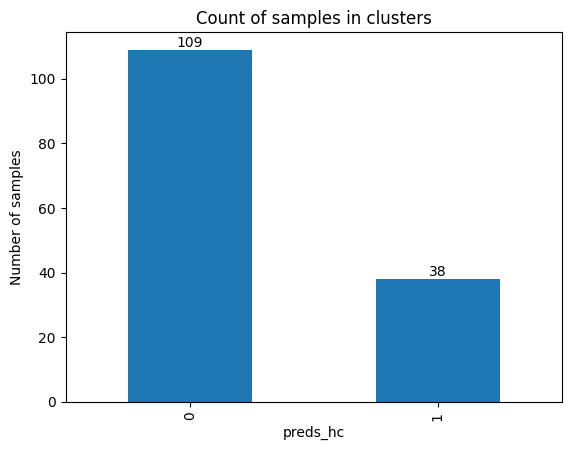

In [250]:
from sklearn.cluster import AgglomerativeClustering

preds_hc = AgglomerativeClustering(n_clusters= 2).fit_predict(transformed_X)
clinical_data["preds_hc"] = preds_hc
ax = clinical_data["preds_hc"].value_counts().plot(kind="bar", title= "Count of samples in clusters", x= "preds_hc", ylabel= "Number of samples")
for container in ax.containers:
    ax.bar_label(container)

In [359]:
logrank_test = multivariate_logrank_test(event_durations= clinical_data["Overall Survival (Months)"], groups= clinical_data["preds_hc"])
logrank_test

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.53 0.47      1.09

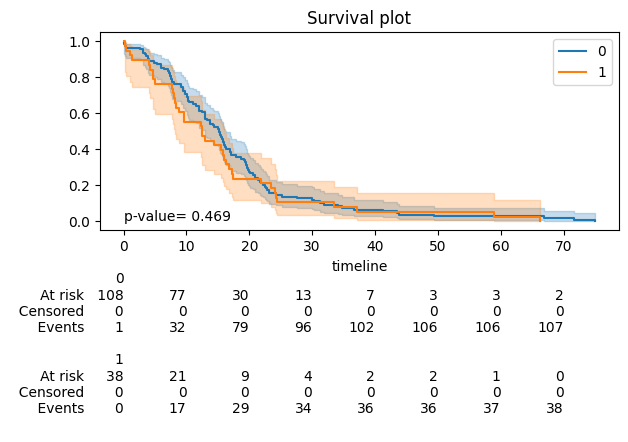

In [360]:
ax = plt.subplot(111)
ax.set_title("Survival plot")
ax.text(0, 0, f"p-value= {round(logrank_test.p_value, 3)}")
clustering_statistical_table.loc["Overall Survival", "HC"] = logrank_test.p_value
kmfs = []
for cluster in sorted(clinical_data["preds_hc"].unique()):
    duration = clinical_data["Overall Survival (Months)"][clinical_data["preds_hc"] == cluster]
    kmf = KaplanMeierFitter().fit(duration, label = str(cluster))
    kmfs.append(kmf)
    ax = kmf.plot(ax=ax)

add_at_risk_counts(*kmfs, ax=ax)
plt.tight_layout()

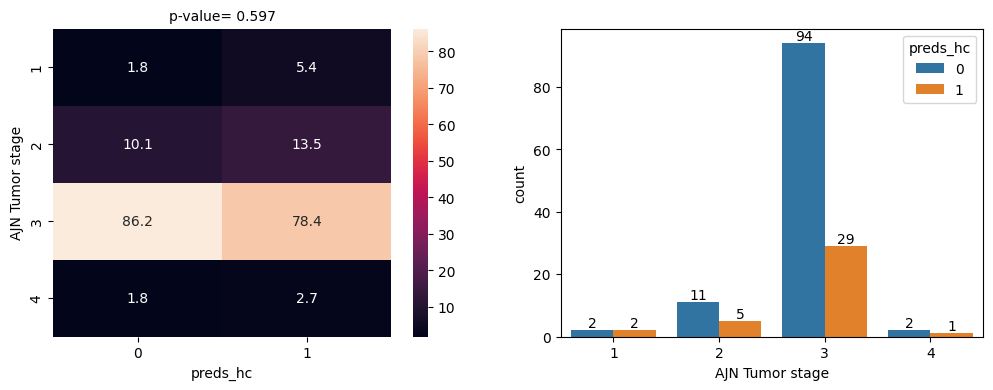

In [361]:
clinical_label = "American Joint Committee on Cancer Tumor Stage Code"
clinical_parameter = clinical_data[clinical_label].str[-1].astype(float).dropna().astype(int)
clinical_label = "AJN Tumor stage"
clinical_parameter = clinical_parameter.rename(clinical_label)
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_hc'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['preds_hc'])).pvalue
clustering_statistical_table.loc["AJCC tumor stage", "HC"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_hc"] = clinical_data['preds_hc']
sns.countplot(data= clinical_parameter, x= clinical_label, hue= "preds_hc", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

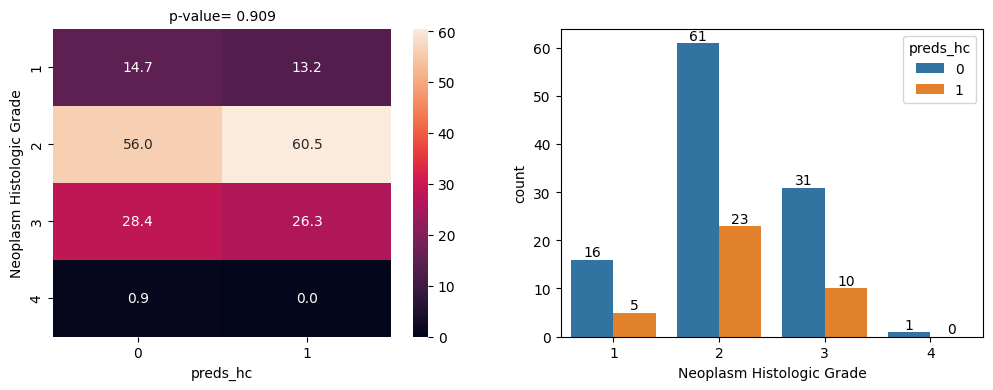

In [362]:
clinical_label = "Neoplasm Histologic Grade"
clinical_parameter = clinical_data[clinical_label].str[-1].astype(float).dropna().astype(int)
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_hc'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['preds_hc'])).pvalue
clustering_statistical_table.loc["AJCC neoplasm histologic grade", "HC"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_hc"] = clinical_data['preds_hc']
sns.countplot(data= clinical_parameter, x= clinical_label, hue= "preds_hc", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

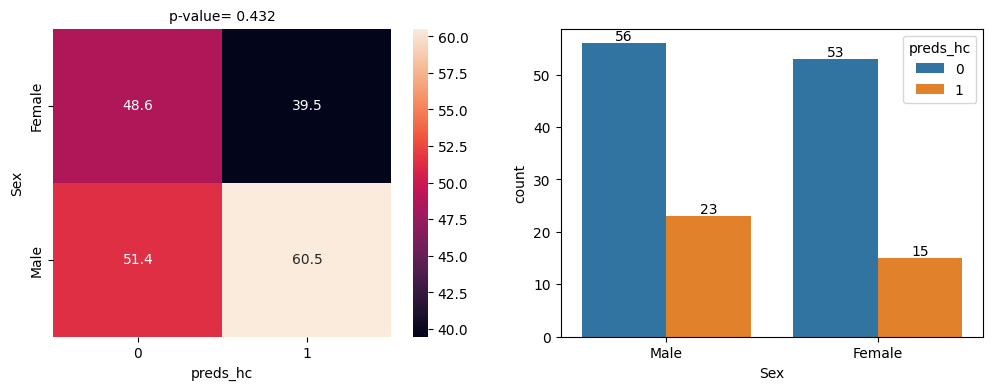

In [363]:
clinical_label = "Sex"
clinical_parameter = clinical_data[clinical_label]
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_hc'])
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_hc'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
clinical_parameter = pd.get_dummies(clinical_data[clinical_label], drop_first=True).astype(int).squeeze()
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['preds_hc'])).pvalue
clustering_statistical_table.loc["Sex", "HC"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_hc"] = clinical_data['preds_hc']
sns.countplot(data= clinical_data, x= clinical_label, hue= "preds_hc", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

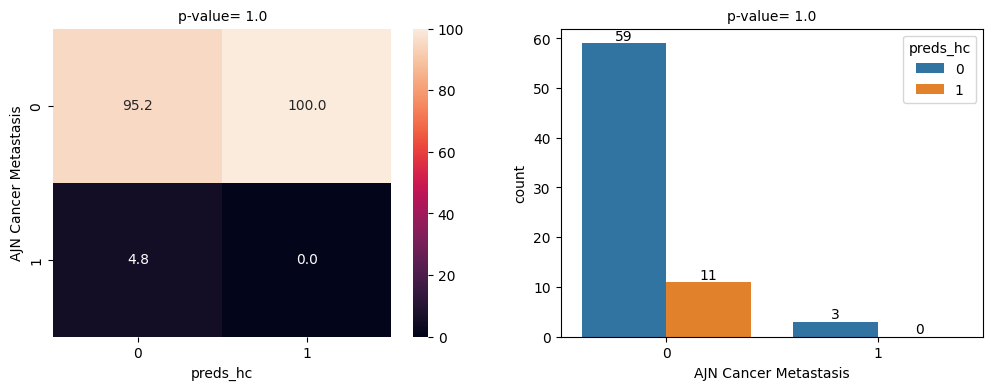

In [364]:
clinical_label = "American Joint Committee on Cancer Metastasis Stage Code"
clinical_parameter = clinical_data[clinical_label].str[-1]
clinical_parameter = clinical_parameter[clinical_parameter != "X"]
clinical_parameter = clinical_parameter.astype(float).dropna().astype(int)
clinical_label = "AJN Cancer Metastasis"
clinical_parameter = clinical_parameter.rename(clinical_label)
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_hc'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['preds_hc'])).pvalue
clustering_statistical_table.loc["AJCC metastasis stage", "HC"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_hc"] = clinical_data['preds_hc']
ax= sns.countplot(data= clinical_parameter, x= clinical_label, hue= "preds_hc")
ax.set_title(f"p-value= {pval}", fontsize= 10)
for container in ax.containers:
    ax.bar_label(container)

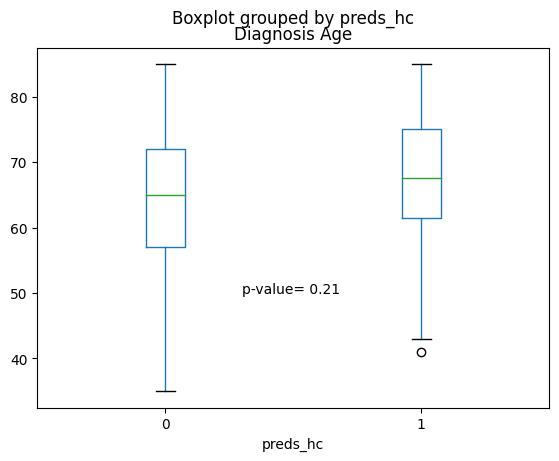

In [367]:
clinical_label = "Diagnosis Age"
clinical_parameter = clinical_data[clinical_label].dropna()
pval = kruskal(*[clinical_parameter[clinical_data['preds_hc'] == cl] for cl in clinical_data['preds_hc'].unique()]).pvalue
clustering_statistical_table.loc["Diagnosis age", "HC"] = pval
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_hc"] = clinical_data['preds_hc']
ax = clinical_parameter.boxplot(column= clinical_label, by= "preds_hc", grid=False)
_ = ax.text(1.3, 50, f"p-value= {round(pval, 3)}")

/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



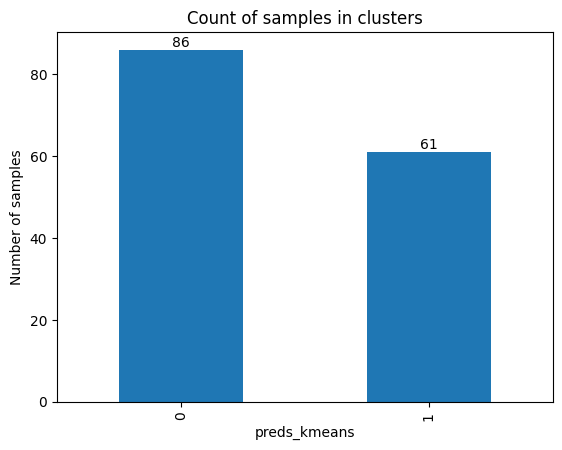

In [272]:
from sklearn.cluster import KMeans

preds_kmeans = KMeans(n_clusters= 2, random_state= 42).fit_predict(transformed_X)
clinical_data["preds_kmeans"] = preds_kmeans
ax = clinical_data["preds_kmeans"].value_counts().plot(kind="bar", title= "Count of samples in clusters", x= "preds_kmeans", ylabel= "Number of samples")
for container in ax.containers:
    ax.bar_label(container)

In [373]:
logrank_test = multivariate_logrank_test(event_durations= clinical_data["Overall Survival (Months)"], groups= clinical_data["preds_kmeans"])
logrank_test

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           1.56 0.21      2.24

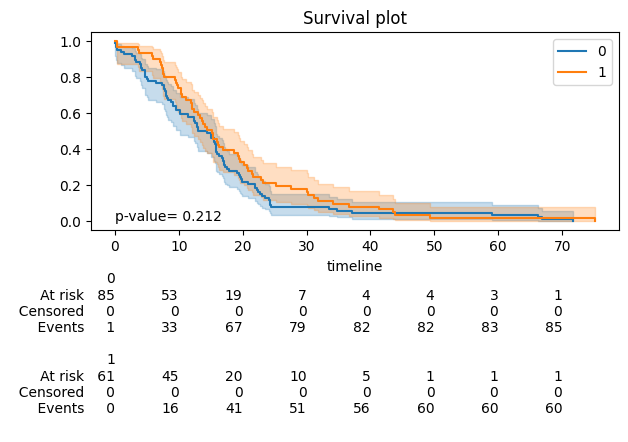

In [374]:
ax = plt.subplot(111)
ax.set_title("Survival plot")
ax.text(0, 0, f"p-value= {round(logrank_test.p_value, 3)}")
clustering_statistical_table.loc["Overall Survival", "K-Means"] = logrank_test.p_value
kmfs = []
for cluster in sorted(clinical_data["preds_kmeans"].unique()):
    duration = clinical_data["Overall Survival (Months)"][clinical_data["preds_kmeans"] == cluster]
    kmf = KaplanMeierFitter().fit(duration, label = str(cluster))
    kmfs.append(kmf)
    ax = kmf.plot(ax=ax)

add_at_risk_counts(*kmfs, ax=ax)
plt.tight_layout()

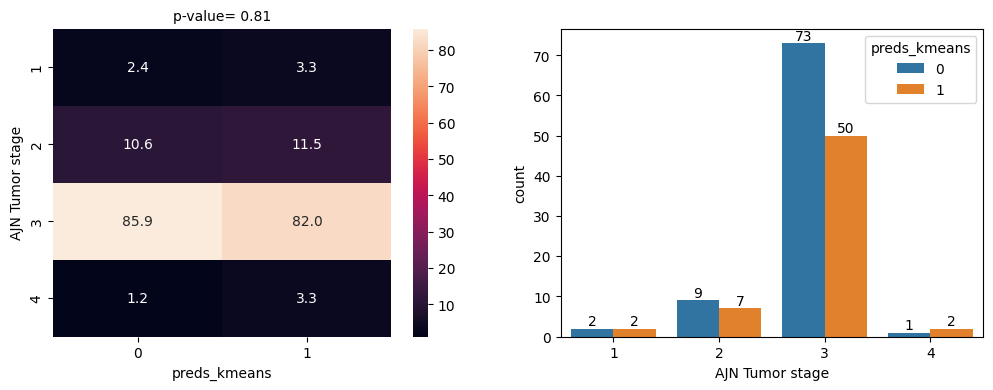

In [375]:
clinical_label = "American Joint Committee on Cancer Tumor Stage Code"
clinical_parameter = clinical_data[clinical_label].str[-1].astype(float).dropna().astype(int)
clinical_label = "AJN Tumor stage"
clinical_parameter = clinical_parameter.rename(clinical_label)
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])).pvalue
clustering_statistical_table.loc["AJCC tumor stage", "K-Means"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_kmeans"] = clinical_data['preds_kmeans']
sns.countplot(data= clinical_parameter, x= clinical_label, hue= "preds_kmeans", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

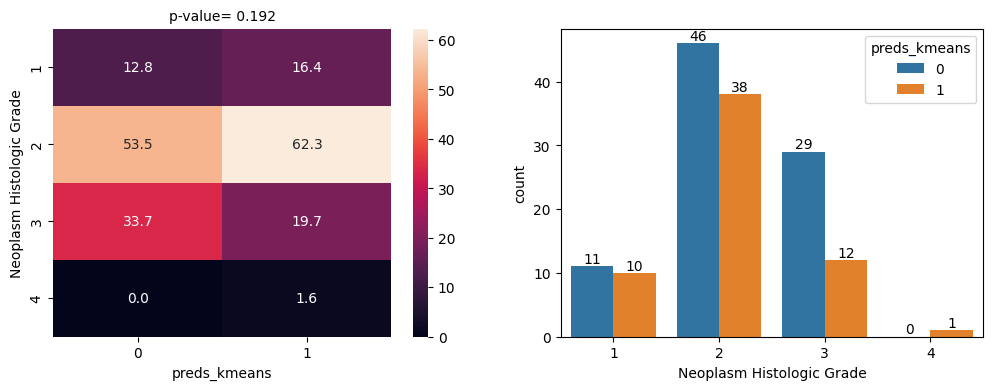

In [376]:
clinical_label = "Neoplasm Histologic Grade"
clinical_parameter = clinical_data[clinical_label].str[-1].astype(float).dropna().astype(int)
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])).pvalue
clustering_statistical_table.loc["AJCC neoplasm histologic grade", "K-Means"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_kmeans"] = clinical_data['preds_kmeans']
sns.countplot(data= clinical_parameter, x= clinical_label, hue= "preds_kmeans", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

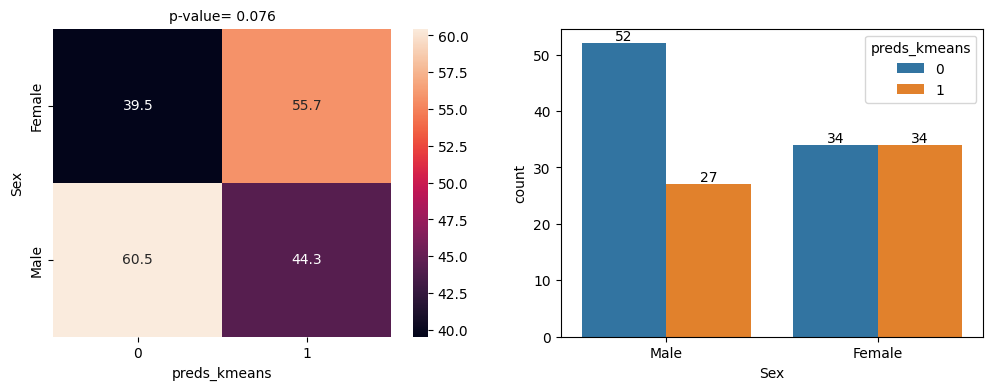

In [377]:
clinical_label = "Sex"
clinical_parameter = clinical_data[clinical_label]
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
clinical_parameter = pd.get_dummies(clinical_data[clinical_label], drop_first=True).astype(int).squeeze()
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])).pvalue
clustering_statistical_table.loc["Sex", "K-Means"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_kmeans"] = clinical_data['preds_kmeans']
sns.countplot(data= clinical_data, x= clinical_label, hue= "preds_kmeans", ax= axes[1])
for container in axes[1].containers:
    axes[1].bar_label(container)

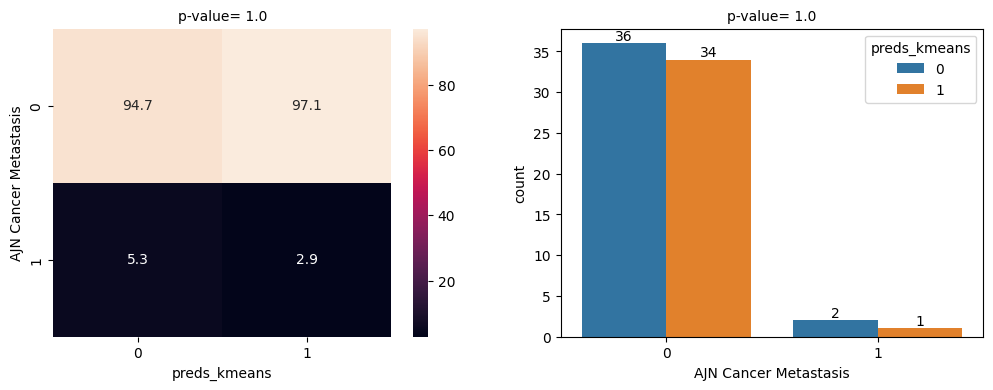

In [378]:
clinical_label = "American Joint Committee on Cancer Metastasis Stage Code"
clinical_parameter = clinical_data[clinical_label].str[-1]
clinical_parameter = clinical_parameter[clinical_parameter != "X"]
clinical_parameter = clinical_parameter.astype(float).dropna().astype(int)
clinical_label = "AJN Cancer Metastasis"
clinical_parameter = clinical_parameter.rename(clinical_label)
fig, axes = plt.subplots(1, 2, figsize= (12, 4))
crosstab = pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])
sns.heatmap(crosstab * 100 / crosstab.sum(0), annot=True, fmt=".1f", ax= axes[0])
pval = chi2_contingency(pd.crosstab(clinical_parameter, clinical_data['preds_kmeans'])).pvalue
clustering_statistical_table.loc["AJCC metastasis stage", "K-Means"] = pval
axes[0].set_title(f"p-value= {round(pval, 3)}", fontsize= 10)
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_kmeans"] = clinical_data['preds_kmeans']
ax= sns.countplot(data= clinical_parameter, x= clinical_label, hue= "preds_kmeans")
ax.set_title(f"p-value= {pval}", fontsize= 10)
for container in ax.containers:
    ax.bar_label(container)

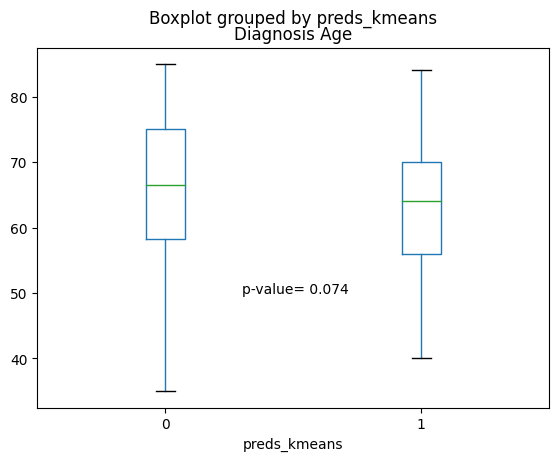

In [379]:
clinical_label = "Diagnosis Age"
clinical_parameter = clinical_data[clinical_label].dropna()
pval = kruskal(*[clinical_parameter[clinical_data['preds_kmeans'] == cl] for cl in clinical_data['preds_kmeans'].unique()]).pvalue
clustering_statistical_table.loc["Diagnosis age", "K-Means"] = pval
clinical_parameter = clinical_parameter.to_frame()
clinical_parameter["preds_kmeans"] = clinical_data['preds_kmeans']
ax = clinical_parameter.boxplot(column= clinical_label, by= "preds_kmeans", grid=False)
_ = ax.text(1.3, 50, f"p-value= {round(pval, 3)}")

In [383]:
print(clustering_statistical_table.to_latex(float_format="{:.3f}".format))

\begin{tabular}{llll}
\toprule
 & Deep clustering & K-Means & HC \\
\midrule
Overall Survival & 0.001 & 0.212 & 0.469 \\
Diagnosis age & 0.920 & 0.074 & 0.210 \\
AJCC tumor stage & 0.970 & 0.810 & 0.597 \\
AJCC metastasis stage & 0.457 & 1.000 & 1.000 \\
AJCC neoplasm histologic grade & 0.876 & 0.192 & 0.909 \\
Sex & 0.359 & 0.076 & 0.432 \\
\bottomrule
\end{tabular}



In [23]:
method = make_pipeline(StandardScaler(), PCA(n_components = 2, random_state = settings.RANDOM_STATE))
plot_data = method.fit_transform(z_full)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1], color = clinical_data["clusters"].astype(str))
fig.show()

In [24]:
method = make_pipeline(StandardScaler(), PCA(n_components = 2, random_state = settings.RANDOM_STATE))
plot_data = method.fit_transform(z_full)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1], color = clinical_data["Overall Survival (Months)"], color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [25]:
method = make_pipeline(StandardScaler(), PCA(n_components = 3, random_state = settings.RANDOM_STATE))
plot_data = method.fit_transform(z_full)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2], color = clusters.astype(str))
fig.show()

In [26]:
method = make_pipeline(StandardScaler(), PCA(n_components = 3, random_state = settings.RANDOM_STATE))
plot_data = method.fit_transform(z_full)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2], color = clinical_data["Overall Survival (Months)"],
                    color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [27]:
method = PCA(n_components = 2, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1], 
                 color = make_pipeline(StandardScaler(), KMeans(n_clusters=optimization_study.best_params["n_clusters"], random_state = settings.RANDOM_STATE)).fit_predict(plot_data).astype(str))
fig.show()

/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [28]:
method = PCA(n_components = 2, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1], color = clinical_data["Overall Survival (Months)"], color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [29]:
method = TSNE(n_components = 2, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1],
                 color = make_pipeline(StandardScaler(), KMeans(n_clusters=optimization_study.best_params["n_clusters"], random_state = settings.RANDOM_STATE)).fit_predict(plot_data).astype(str))
fig.show()

/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [30]:
method = TSNE(n_components = 2, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1], color = clinical_data["Overall Survival (Months)"], color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [31]:
method = UMAP(n_components = 2, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1],
                 color = make_pipeline(StandardScaler(), KMeans(n_clusters=optimization_study.best_params["n_clusters"], random_state = settings.RANDOM_STATE)).fit_predict(plot_data).astype(str))
fig.show()

/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [32]:
method = UMAP(n_components = 2, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter(x = plot_data[:, 0], y = plot_data[:, 1], color = clinical_data["Overall Survival (Months)"], color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [33]:
method = PCA(n_components = 3, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2],
                    color = make_pipeline(StandardScaler(), KMeans(n_clusters=optimization_study.best_params["n_clusters"], random_state = settings.RANDOM_STATE)).fit_predict(plot_data).astype(str))
fig.show()

/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [34]:
method = PCA(n_components = 3, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2], color = clinical_data["Overall Survival (Months)"], 
                    color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [35]:
method = TSNE(n_components = 3, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2],
                    color = make_pipeline(StandardScaler(), KMeans(n_clusters=optimization_study.best_params["n_clusters"], random_state = settings.RANDOM_STATE)).fit_predict(plot_data).astype(str))
fig.show()

/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [36]:
method = TSNE(n_components = 3, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2], color = clinical_data["Overall Survival (Months)"], 
                    color_continuous_scale=px.colors.sequential.Bluered)
fig.show()

In [37]:
method = UMAP(n_components = 3, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2],
                    color = make_pipeline(StandardScaler(), KMeans(n_clusters=optimization_study.best_params["n_clusters"], random_state = settings.RANDOM_STATE)).fit_predict(plot_data).astype(str))
fig.show()

/home/alberto/anaconda3/envs/course_interpretability_dl/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [38]:
method = UMAP(n_components = 3, random_state = settings.RANDOM_STATE)
plot_data = method.fit_transform(transformed_X)
fig = px.scatter_3d(x = plot_data[:, 0], y = plot_data[:, 1], z = plot_data[:, 2], color = clinical_data["Overall Survival (Months)"],
                    color_continuous_scale=px.colors.sequential.Bluered)
fig.show()